In [88]:
import numpy as np
import matplotlib.pyplot as plt
from numpy.fft import rfftn,fftfreq,rfftfreq

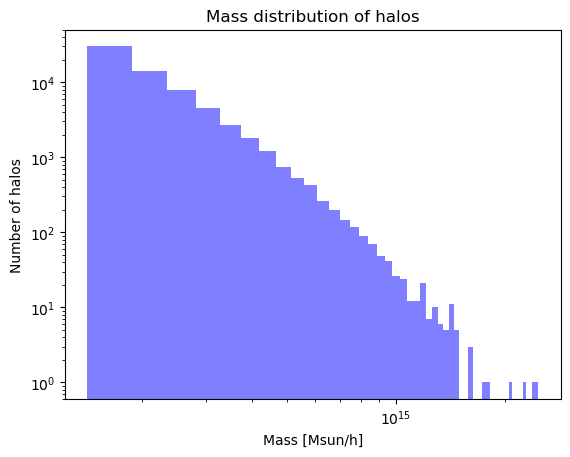

Cell size:  42.0
Mean density in the cell:  0.24880599975585938


In [89]:
L=2688
volume=L**3

#create particles
x,y,z=np.genfromtxt('cluster2.txt',usecols=(1,2,3),unpack=True)/1000  #sono in kpc/h!!!, faccio/1000
mass = np.genfromtxt('cluster2.txt',usecols=(7),unpack=True) #masse degli aloni in Msun/h
n_points=len(x)
density=n_points/volume

plt.hist(mass, bins = 50, color = 'blue', alpha = 0.5)
plt.xlabel('Mass [Msun/h]')
plt.ylabel('Number of halos')
plt.title('Mass distribution of halos')
plt.xscale('log')
plt.yscale('log')
plt.show()

# %%
n_cells=64 #è un nostro parametro, def fino  ache scala voglio misuare Pk, meglio se è multiplo di 2 per dopo
cell_size=L/n_cells
print("Cell size: ",cell_size) #mpc/h

#compute the mean density
cell_mean_density=n_points/n_cells**3
print("Mean density in the cell: ",cell_mean_density) #mpc**-3/h**3

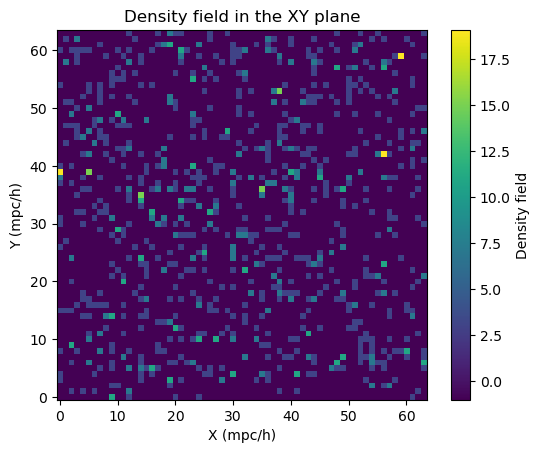

In [90]:
#create density grid with histogramdd
grid,edges=np.histogramdd((x,y,z),bins=(n_cells,n_cells,n_cells),range=((0,L),(0,L),(0,L)))

#compute the density field
density_field=(grid-cell_mean_density)/cell_mean_density 

# %%
plt.imshow(density_field[:,:,0],origin='lower',cmap='viridis')
plt.colorbar(label='Density field')
plt.title('Density field in the XY plane')
plt.xlabel('X (mpc/h)')
plt.ylabel('Y (mpc/h)')
plt.show()

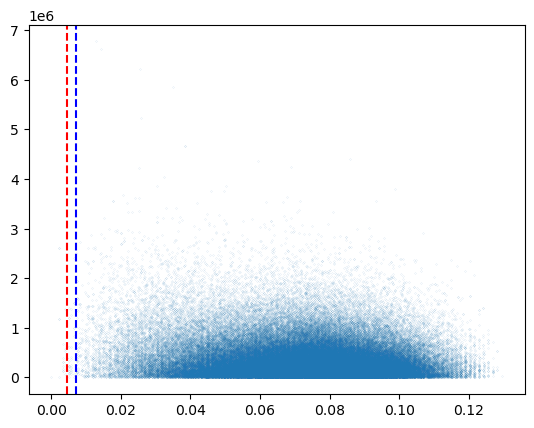

In [91]:
delta_k=rfftn(density_field)/n_cells**3  #normmalizzo per il number di celle  
#è oggetto grande: (64,64,33) e vale che f(-k)=f*(k) e f(k)=f(-k) (coniugato)

#create the k grid
kF=2*np.pi/L  #fondamental frequency in mpc**-1/h
H=L/n_cells
kN=np.pi/H   #Nyquist frequency in mpc**-1/h
kx=fftfreq(n_cells,d=1/n_cells)*kF
ky=fftfreq(n_cells,d=1/n_cells)*kF
kz=rfftfreq(n_cells,d=1/n_cells)*kF

KX,KY,KZ=np.meshgrid(kx,ky,kz)
KK=np.sqrt(KX**2+KY**2+KZ**2)  

#calcolo spettro di pot su griglia
pk_grid=delta_k*np.conjugate(delta_k)*volume  #metto il volume perchè non sono nel continuo ma nel discreto
#ora devo fare binning griglia per avere p(|k|)
#Binning
c=1
k_edges=np.arange(kF,kN,c*kF) 
k_bins=0.5*(k_edges[1:]+k_edges[:-1])

plt.plot(KK.flatten(),pk_grid.flatten(),'.',markersize=0.1)
plt.axvline(k_edges[1], color='red', linestyle='--', label='kF')
plt.axvline(k_edges[2], color='blue', linestyle='--', label='kN')
plt.show()

/tmp/ipykernel_11541/3298787884.py:6: ComplexWarning: Casting complex values to real discards the imaginary part
  pk_averaged[i]=np.mean(pk_grid.flatten()[mask])


k_bins:  0.0035062418008814655
k_bins:  0.005843736334802443
k_bins:  0.00818123086872342
k_bins:  0.010518725402644397
k_bins:  0.012856219936565376
k_bins:  0.015193714470486352
k_bins:  0.017531209004407328
k_bins:  0.019868703538328307
k_bins:  0.02220619807224928
k_bins:  0.02454369260617026
k_bins:  0.026881187140091238
k_bins:  0.02921868167401221
k_bins:  0.03155617620793319
k_bins:  0.033893670741854176
k_bins:  0.03623116527577515
k_bins:  0.03856865980969612
k_bins:  0.04090615434361711
k_bins:  0.04324364887753808
k_bins:  0.04558114341145905
k_bins:  0.04791863794538004
k_bins:  0.05025613247930101
k_bins:  0.05259362701322198
k_bins:  0.05493112154714297
k_bins:  0.05726861608106394
k_bins:  0.059606110614984914
k_bins:  0.06194360514890589
k_bins:  0.06428109968282686
k_bins:  0.06661859421674785
k_bins:  0.06895608875066883
k_bins:  0.07129358328458979
k_bins:  0.07363107781851078


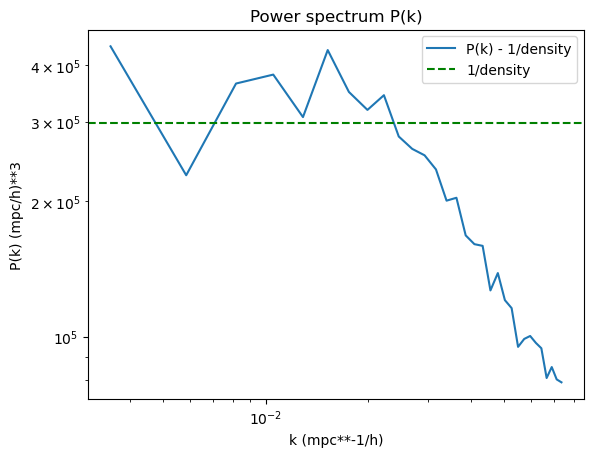

In [95]:
pk_averaged=np.zeros(k_bins.shape)
k_averaged=np.zeros(k_bins.shape)

for i in range(len(k_bins)):
    mask=(KK.flatten()>=k_edges[i]) & (KK.flatten()<k_edges[i+1])
    pk_averaged[i]=np.mean(pk_grid.flatten()[mask])
    k_averaged[i]=np.mean(KK.flatten()[mask])
    print("k_bins: ",k_bins[i])
    
plt.loglog(k_bins,pk_averaged-1./density,label='P(k) - 1/density')
plt.axhline(1./density, color='green', linestyle='--', label='1/density')
plt.xlabel('k (mpc**-1/h)')
plt.ylabel('P(k) (mpc/h)**3')
plt.title('Power spectrum P(k)')
plt.legend()
plt.show()

Note: redshifts have been re-sorted (earliest first)


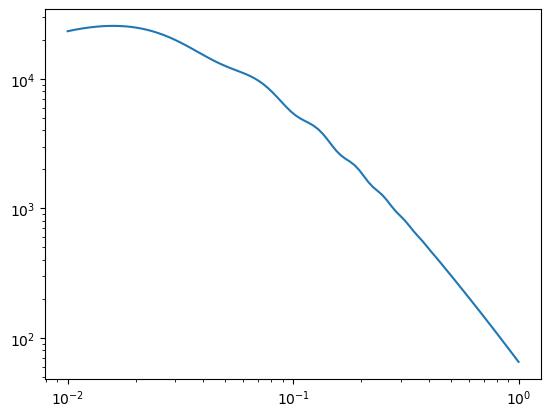

In [100]:
import camb

camb_params = camb.CAMBparams()
 
h = 0.704
ombh2 = 0.022
omega_m = 0.272
omch2= omega_m * h**2 - ombh2

camb_params.set_cosmology(
                       H0=70.4,   # H0
                       ombh2=0.022, # Omega_b * h^2
                       omch2=0.12,  # Omega_c * h^2
                       mnu=0, 
                       num_massive_neutrinos = 0
                       )

camb_params.InitPower.set_params(ns=0.965)
camb_params.set_matter_power(redshifts=[0., 0.8], kmax=2.0)
camb_result = camb.get_results(camb_params)

k, z, pk = camb_result.get_matter_power_spectrum(minkh=0.01, npoints=100)

sigma8_z0 = camb_result.get_sigma8_0()

pk_renorm = pk[0] * (0.809)**2/sigma8_z0**2
plt.loglog(k, pk_renorm)

ValueError: x and y must have same first dimension, but have shapes (31,) and (100,)

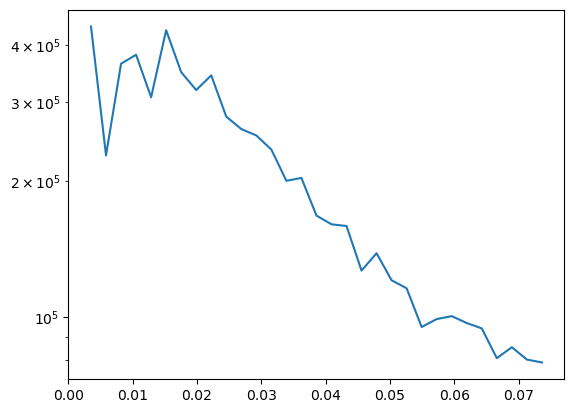

In [94]:
#sovrapponi quello teroico a quello simulato
plt.semilogy(k_bins,pk_averaged-1./density,label='P(k) - 1/density')
plt.plot(k_bins, pk_renorm,label='P(k) theoretical')

